In [1]:
# things to do/doubts/discussions
# test cases are not sucessful - its not overfitting
# model sometimes give constant loss over epochs and gives poor results on prediction
# is the loss value supposed to reduce continously
# should we do augmentation of validation data ?
# All values are already between -1 to +1. should we do scaling on top of this ?
# if we are adding scaling of data, how to ensure that when it is being tested would give out rescaled data


# how to save subclassing api
# hyperparameter tuning
# how to save the best model among all the epochs
# should we shuffle repeat, prefetch etc ?
# incase of early stopping - what metric is to be monitored - val loss or val mse ?


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.keras.backend.set_floatx('float64')
tf.compat.v1.enable_eager_execution()

from utility import *

# GPUs Available:  1


In [3]:
#load the data
X_train, Y_train, X_validation, Y_validation, X_test = load_data(100)

In [4]:
# defining the parameters
batch_size = 32
epochs = 1000
# steps_per_epoch = sum(train_occurences) / batch_size
starter_learning_rate = 1e-1
end_learning_rate = 1e-8
decay_steps = epochs * 3
scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate= starter_learning_rate,
    decay_steps= decay_steps,
    end_learning_rate= end_learning_rate,
    power=1)
kernel_regularizer=tf.keras.regularizers.L1L2(0.01)
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',patience=20)]
initializer=tf.keras.initializers.HeUniform

In [5]:
# generating augmented data
X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)

In [6]:
# NN Model
class NNmodel():
    def model_structure():
        model = tf.keras.models.Sequential()
        model.add(Hidden_layer(4, kernel_regularizer=kernel_regularizer, initializer=initializer))
        model.add(Output_layer(2, kernel_regularizer=kernel_regularizer, initializer=initializer))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
                    loss='mean_squared_error',
                    metrics = [tf.keras.metrics.MeanSquaredError()]
        )
        return model

Epoch 1/1000
4/4 - 1s - loss: 0.4822 - mean_squared_error: 0.3695 - val_loss: 0.3587 - val_mean_squared_error: 0.2773 - 1s/epoch - 331ms/step
Epoch 2/1000
4/4 - 0s - loss: 0.3652 - mean_squared_error: 0.2873 - val_loss: 0.3436 - val_mean_squared_error: 0.2646 - 76ms/epoch - 19ms/step
Epoch 3/1000
4/4 - 0s - loss: 0.3470 - mean_squared_error: 0.2681 - val_loss: 0.3130 - val_mean_squared_error: 0.2301 - 73ms/epoch - 18ms/step
Epoch 4/1000
4/4 - 0s - loss: 0.3136 - mean_squared_error: 0.2291 - val_loss: 0.2908 - val_mean_squared_error: 0.2001 - 76ms/epoch - 19ms/step
Epoch 5/1000
4/4 - 0s - loss: 0.2800 - mean_squared_error: 0.1847 - val_loss: 0.2587 - val_mean_squared_error: 0.1533 - 80ms/epoch - 20ms/step
Epoch 6/1000
4/4 - 0s - loss: 0.2587 - mean_squared_error: 0.1506 - val_loss: 0.2568 - val_mean_squared_error: 0.1422 - 83ms/epoch - 21ms/step
Epoch 7/1000
4/4 - 0s - loss: 0.2386 - mean_squared_error: 0.1207 - val_loss: 0.2343 - val_mean_squared_error: 0.1060 - 76ms/epoch - 19ms/step


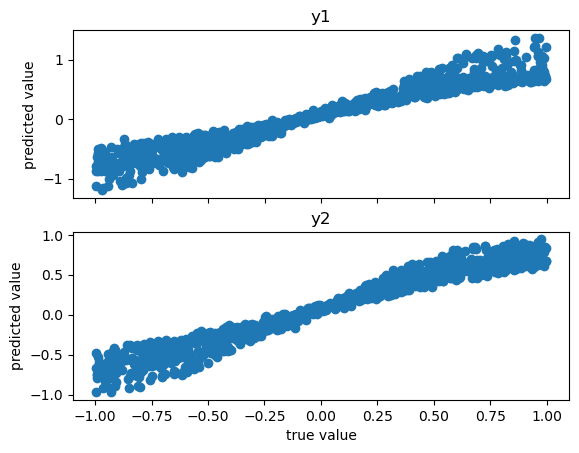

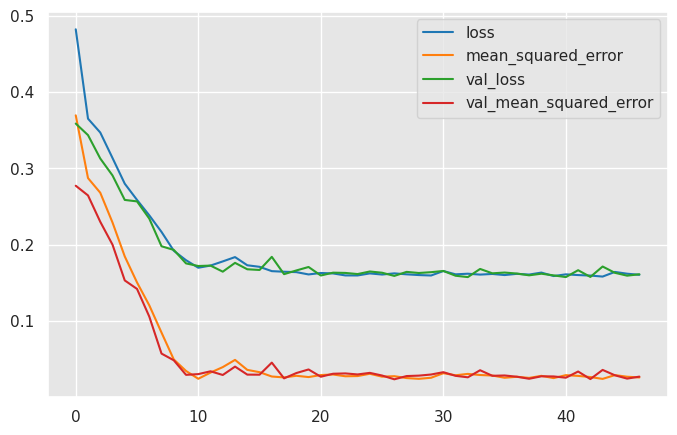

1/1 [==============================] - 0s 24ms/step
[[ 0.08412244  0.07808488]
 [-0.25698053  0.38369826]
 [-0.24536372 -0.23319817]
 [ 0.4252254  -0.22752851]
 [ 0.41360859  0.38936792]
 [-0.42753201  0.53650496]
 [ 0.59577855 -0.38034226]
 [-0.4957526   0.59762763]
 [ 0.59577855 -0.38034226]
 [-0.41009758 -0.38887887]]


In [7]:
# Model 1 - NN fitting with Normal data
model = NNmodel.model_structure()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )  
model_eval(model, history, X_validation, Y_validation, X_train, Y_train, batch_size, X_test)

Epoch 1/1000
25/25 - 1s - loss: 0.3520 - mean_squared_error: 0.2572 - val_loss: 0.2221 - val_mean_squared_error: 0.0983 - 896ms/epoch - 36ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1979 - mean_squared_error: 0.0595 - val_loss: 0.1673 - val_mean_squared_error: 0.0230 - 219ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1716 - mean_squared_error: 0.0367 - val_loss: 0.1570 - val_mean_squared_error: 0.0271 - 229ms/epoch - 9ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1707 - mean_squared_error: 0.0373 - val_loss: 0.1575 - val_mean_squared_error: 0.0235 - 146ms/epoch - 6ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1714 - mean_squared_error: 0.0385 - val_loss: 0.1569 - val_mean_squared_error: 0.0231 - 208ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1680 - mean_squared_error: 0.0335 - val_loss: 0.1570 - val_mean_squared_error: 0.0240 - 183ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1674 - mean_squared_error: 0.0345 - val_loss: 0.1559 - val_mean_squared_error: 0.0223 - 133ms/e

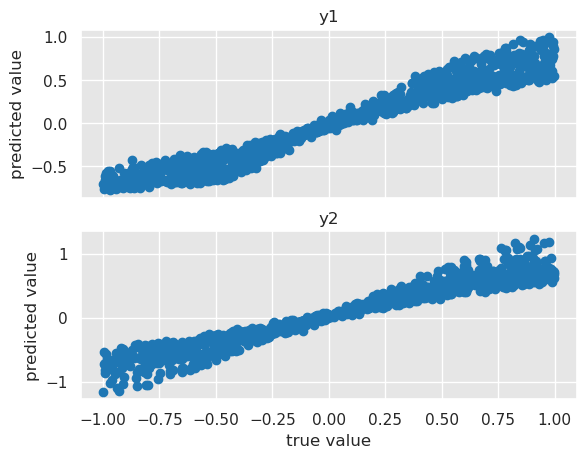

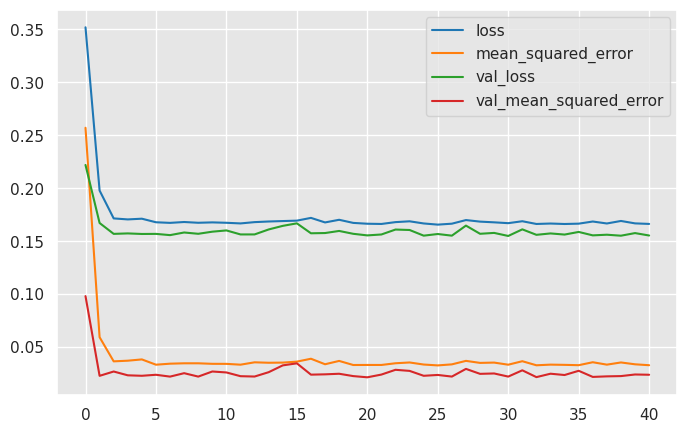

1/1 [==============================] - 0s 23ms/step
[[-0.02283845  0.03265384]
 [-0.34410192  0.34620583]
 [-0.33223655 -0.27366722]
 [ 0.29842502 -0.28089815]
 [ 0.28655884  0.33897325]
 [-0.50473365  0.50298182]
 [ 0.45905676 -0.43767415]
 [-0.56898635  0.56569222]
 [ 0.45905676 -0.43767415]
 [-0.4869356  -0.42682774]]


In [12]:
# Model 2 - NN fitting with Augmented data

model = NNmodel.model_structure()
history = model.fit(X_train_Aug, Y_train_Aug, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )
model_eval(model, history, X_validation, Y_validation, X_train_Aug, Y_train_Aug, batch_size, X_test)

In [9]:
# Equivariant NN Model
class EqNNmodel():
    def model_structure():
        model = tf.keras.models.Sequential()
        model.add(EqHidden_layer(4, kernel_regularizer=kernel_regularizer, initializer=initializer))
        model.add(EqOutput_layer(2, kernel_regularizer=kernel_regularizer, initializer=initializer))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
                    loss='mean_squared_error',
                    metrics = [tf.keras.metrics.MeanSquaredError()]
        )
        return model

Epoch 1/1000
4/4 - 1s - loss: 0.4221 - mean_squared_error: 0.3802 - val_loss: 0.2500 - val_mean_squared_error: 0.2114 - 1s/epoch - 253ms/step
Epoch 2/1000
4/4 - 0s - loss: 0.2254 - mean_squared_error: 0.1865 - val_loss: 0.0864 - val_mean_squared_error: 0.0449 - 104ms/epoch - 26ms/step
Epoch 3/1000
4/4 - 0s - loss: 0.0905 - mean_squared_error: 0.0460 - val_loss: 0.1002 - val_mean_squared_error: 0.0489 - 184ms/epoch - 46ms/step
Epoch 4/1000
4/4 - 0s - loss: 0.1127 - mean_squared_error: 0.0605 - val_loss: 0.1098 - val_mean_squared_error: 0.0577 - 117ms/epoch - 29ms/step
Epoch 5/1000
4/4 - 0s - loss: 0.0973 - mean_squared_error: 0.0463 - val_loss: 0.0647 - val_mean_squared_error: 0.0170 - 86ms/epoch - 22ms/step
Epoch 6/1000
4/4 - 0s - loss: 0.0738 - mean_squared_error: 0.0273 - val_loss: 0.0664 - val_mean_squared_error: 0.0225 - 80ms/epoch - 20ms/step
Epoch 7/1000
4/4 - 0s - loss: 0.0823 - mean_squared_error: 0.0389 - val_loss: 0.0685 - val_mean_squared_error: 0.0255 - 86ms/epoch - 21ms/st

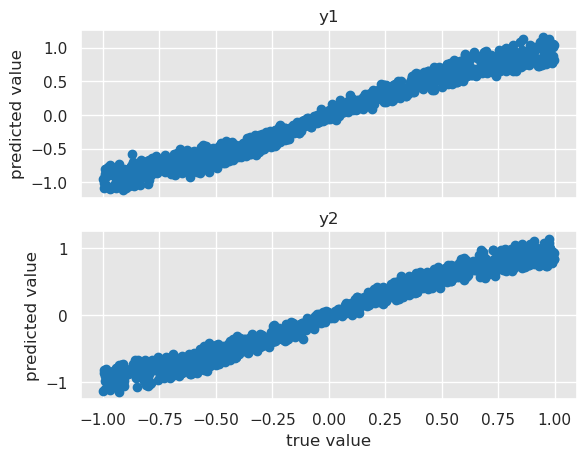

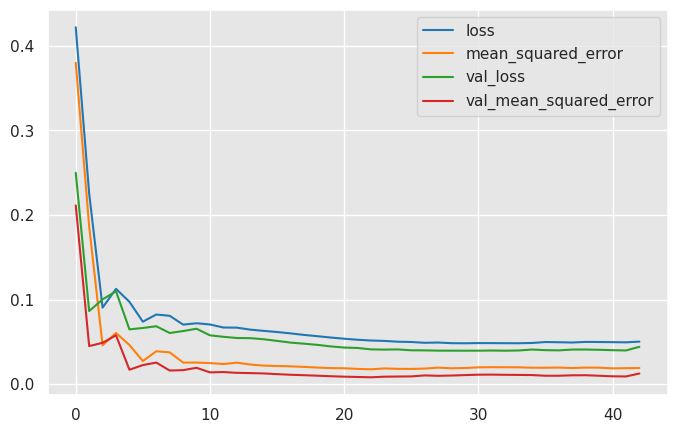

1/1 [==============================] - 0s 23ms/step
[[ 0.          0.        ]
 [-0.45494916  0.45494916]
 [-0.45494916 -0.45494916]
 [ 0.45494916 -0.45494916]
 [ 0.45494916  0.45494916]
 [-0.60393251  0.60393251]
 [ 0.60393251 -0.60393251]
 [-0.64942742  0.64942742]
 [ 0.60393251 -0.60393251]
 [-0.60393251 -0.60393251]]


In [13]:
# Model 3 Equivariant NN - on Normal data
model = EqNNmodel.model_structure()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )
model_eval(model, history, X_validation, Y_validation, X_train, Y_train, batch_size, X_test)

Epoch 1/1000
25/25 - 1s - loss: 0.1540 - mean_squared_error: 0.0909 - val_loss: 0.0789 - val_mean_squared_error: 0.0222 - 937ms/epoch - 37ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.0857 - mean_squared_error: 0.0305 - val_loss: 0.0732 - val_mean_squared_error: 0.0211 - 144ms/epoch - 6ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0796 - mean_squared_error: 0.0298 - val_loss: 0.0656 - val_mean_squared_error: 0.0192 - 140ms/epoch - 6ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0692 - mean_squared_error: 0.0250 - val_loss: 0.0550 - val_mean_squared_error: 0.0148 - 156ms/epoch - 6ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0604 - mean_squared_error: 0.0227 - val_loss: 0.0436 - val_mean_squared_error: 0.0099 - 110ms/epoch - 4ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0500 - mean_squared_error: 0.0191 - val_loss: 0.0401 - val_mean_squared_error: 0.0116 - 107ms/epoch - 4ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0485 - mean_squared_error: 0.0194 - val_loss: 0.0394 - val_mean_squared_error: 0.0103 - 116ms/e

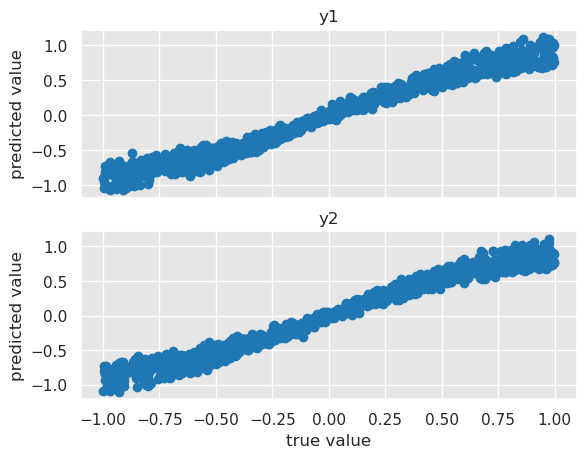

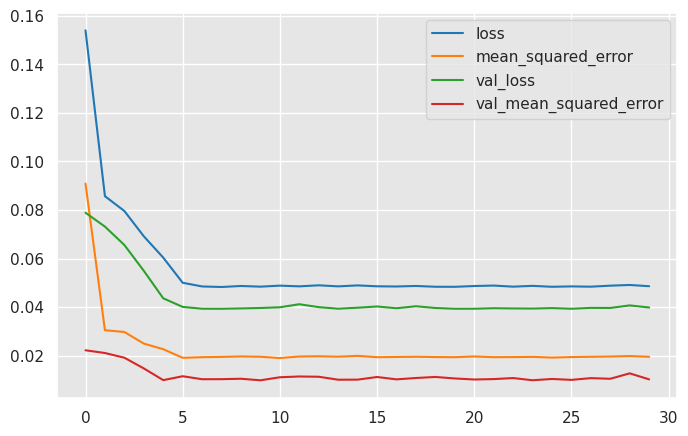

1/1 [==============================] - 0s 21ms/step
[[ 0.          0.        ]
 [-0.41371517  0.41371517]
 [-0.41371517 -0.41371517]
 [ 0.41371517 -0.41371517]
 [ 0.41371517  0.41371517]
 [-0.52140515  0.52140515]
 [ 0.52140515 -0.52140515]
 [-0.56448115  0.56448115]
 [ 0.52140515 -0.52140515]
 [-0.52140515 -0.52140515]]


In [14]:
# Model 4 Equivariant NN - on Augmented data
model = EqNNmodel.model_structure()
history = model.fit(X_train_Aug, Y_train_Aug, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation, Y_validation),
                    callbacks=callbacks,
                    # shuffle=True
                    )
model_eval(model, history, X_validation, Y_validation, X_train_Aug, Y_train_Aug, batch_size, X_test)